# Anomaly Detection of Wikipedia Visits for R page

The aim of this study to learn anomaly detection in time series using Facebook Prophet. I am following the works of Michael Duan and Cathy Xu published in this [blog](https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473). The authors worked on seismic data but unfortunately didn't shaered their data online. Thus, I searched for [benchmark datasets for time series anomaly detection](https://www.researchgate.net/post/What_are_anomaly_detection_benchmark_datasets). I decided to use *Yahoo - a benchmark dataset for TSAD* which is a dataset released by Yahoo Labs to detect unusual traffic on Yahoo servers but accessing to that dataset needs Yahoo's approval. I made my request and in the time being I will work on the logged Wikipedia visits to the [R (Programming Language)](https://en.wikipedia.org/wiki/R_%28programming_language%29) page which can be accessed from [here](https://github.com/facebook/prophet/tree/master/examples). 


## Explaratory Data Analysis

The dataset composed of two columns one for date (ds), and one for page visits (y). There are 2863 samples in the set.

In [14]:
import pandas as pd
df = pd.read_csv('../input/example_wp_log_R_outliers1.csv')
df.head()

ds         y
0  2008-01-30  5.976351
1  2008-01-16  6.049733
2  2008-01-17  6.011267
3  2008-01-14  5.953243
4  2008-01-15  5.910797

In [15]:
df.shape

(2863, 2)

The data is collected in between 2008 and 2015 for 8 years.

In [16]:
print(df.ds.min())
print(df.ds.max())

2008-01-01
2015-12-31


There are no missing values.

In [17]:
df.isna().sum()

ds    0
y     0
dtype: int64

In the original version of the dataframe date column is stored as object and has to be converted to datetime.

In [18]:
df.dtypes

ds     object
y     float64
dtype: object

In [19]:
df.ds = pd.to_datetime(df.ds, yearfirst=True, format= '%Y-%m-%d')
#print(df.head())

df = df.set_index("ds")
#df_vis.index = pd.to_datetime(df_vis.index)

print(df.head())

                   y
ds                  
2008-01-30  5.976351
2008-01-16  6.049733
2008-01-17  6.011267
2008-01-14  5.953243
2008-01-15  5.910797


Wikipedia hits for R page, seems to get saturated after a while. Logistic growth model of Prophet might be a good choice.

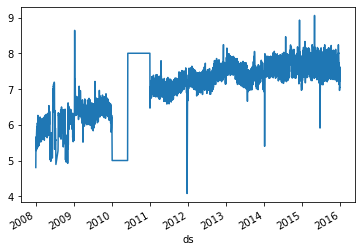

In [20]:
import matplotlib.pyplot as plt
df.y.plot()
plt.show()

For plotting purposes, index of the dataframe was set equal to ds. This resulted in loosing ds column but Prophet needs ds and y columns. Now, we have to change the columns back to normal.

In [21]:
df.columns

Index(['y'], dtype='object')

In [22]:
df = pd.read_csv('../input/example_wp_log_R_outliers1.csv')
df.ds = pd.to_datetime(df.ds, yearfirst=True, format= '%Y-%m-%d')
print(df.dtypes)
df.head()

ds    datetime64[ns]
y            float64
dtype: object


ds         y
0 2008-01-30  5.976351
1 2008-01-16  6.049733
2 2008-01-17  6.011267
3 2008-01-14  5.953243
4 2008-01-15  5.910797

### Peculiar Case of Constant Visits in 2010

Interestingly, in between Jan. 1st, 2010 and Jan. 1st, 2011 the plot seems awkward. In the first half of the year Wikipedia page gets a constant hit of 5 visits per day and in the second half of the year this number is increased to 8.

(353, 2)


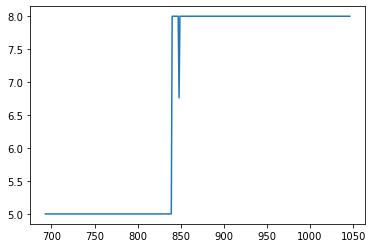

In [23]:
from datetime import datetime
df_gap = df[df.ds > datetime(2010, 1, 1)]
df_gap = df_gap[df_gap.ds < datetime(2011, 1, 1)]
print(df_gap.shape)
df_gap.y.plot()

A quick glance at the descriptive statistics of the dataset tells us that median is larger than the mean. Thus, the distribution of the page visits are negatively skewed.

In [24]:
df.describe()

y
count  2863.000000
mean      7.106230
std       0.845066
min       4.077537
25%       6.629363
50%       7.325149
75%       7.789247
max       9.057539

## Check for Stationarity

### Histogram

By plotting the page hit distribution of time series we obtained the plot below. Upon visual inspection, it is appearent that the distribution is not normal, highly skewed to the left.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002842C1DC848>]],
      dtype=object)

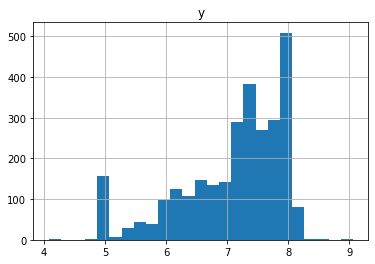

In [25]:
df.hist(bins=25)

### QQ Plot

Another way of checking stationarity is According to the QQ plot below, the scatter plot of points in a diagonal line does not fit the expected diagonal pattern for a sample from a Gaussian distribution. So our distribution is not normal, hence our time series data is non-stationary.

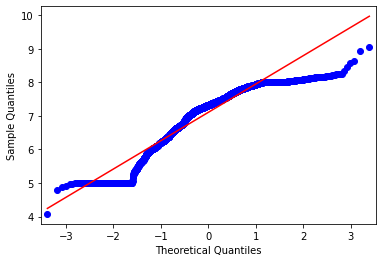

In [26]:
# QQ Plot
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(df.y, line='s')
pyplot.show()

### Global vs. Local Test

We can also proved non-stationarity by splitting the time series into two contiguous sequences. Then we calculate the mean and variance of each group of numbers and compare the values. The parameters of those two groups are very different from eachother, so we conclude that we are dealing with a non-stationary time series data.

In [27]:
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=6.601593, mean2=7.611219
variance1=0.807719, variance2=0.110141


Due to non-stationary nature of the data we cannot use any autoregressive model in our analysis, so an additive model like Facebook's Prophet would be more appropriate.

## Check for Seasonality

### Seasonal Decomposition

According to the lecture notes of Andrius Buteikis on [Time series with trend and seasonality
components](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf), time series can be decompoesed in two ways:
+ **Additive Form:** used when magnitidute of the seasonal fluctuation does not vary with the level of the series
+ **Multiplicative Form:** used when the seasonal fluctuations increases/decreases with the trend as it is shown in [Facebook's Prophet Documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html).

Since there is no appearent seasonality rising with the increasing trend in our data, we decided to go with the additive model.

We first tried to use Pandas' *infer_freq* method could not infer the frequency of the time series, the frequency cannot be inferred automatically.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model="multiplicative")
result.plot()
pyplot.show()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [29]:
print(pd.infer_freq(df.ds, warn=True))

None


Since frequency cannot be inferred, seasonal decomposition cannot be made without explicityly defining the period. Upon experimenting with period we observed no weekly seasonaliy.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

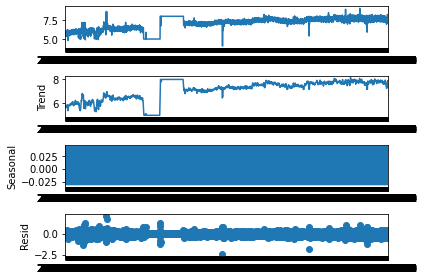

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=7)
result.plot()
pyplot.show()

When the period set to length of a month, fluctuations start to appear.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

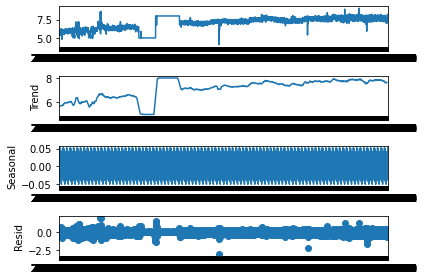

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=30)
result.plot()
pyplot.show()

When period set to a length of a quarter:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

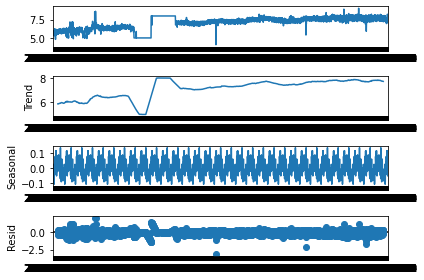

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=round(365.25/4))
result.plot()
pyplot.show()

When period set to a length of a year:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

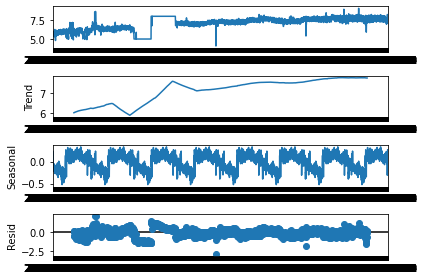

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=round(365.25))
result.plot()
pyplot.show()

### Autocorrelation Plot

According to the [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go)., "If there is significant seasonality, the autocorrelation plot should show spikes at lags equal to the period. For example, for monthly data, if there is a seasonality effect, we would expect to see significant peaks at lag 12, 24, 36, and so on (although the intensity may decrease the further out we go)." The same discussion approved by Rob J Hyndman and George Athanasopoulos in [Forecasting: Principles and Practice](https://otexts.com/fpp3/acf.html), too. Since there is no oscillation appearent in ACF we conclude that there is no seasonality present in the data.

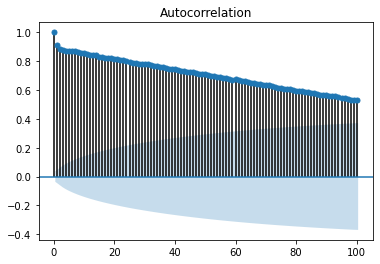

In [34]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags = 100)
pyplot.show()

## Feature Engineering

According to ACF plot, no seasonality is observed in the data but I still believe that weekday visit count of R page can be different then weekends. So , I thought it would be beneficial to create a *weekend* flag and use it as an regressor later.

In [36]:
df['weekday'] = pd.to_datetime(df['ds']).dt.dayofweek  # monday = 0, sunday = 6
df['weekend'] = 0          # Initialize the column with default value of 0
df.loc[df['weekday'].isin([5, 6]), 'weekend'] = 1  # 5 and 6 correspond to Sat and Sun
df.head()

ds         y  weekday  weekend
0 2008-01-30  5.976351        2        0
1 2008-01-16  6.049733        2        0
2 2008-01-17  6.011267        3        0
3 2008-01-14  5.953243        0        0
4 2008-01-15  5.910797        1        0

## Modelling

### Linear Model without Seasonality

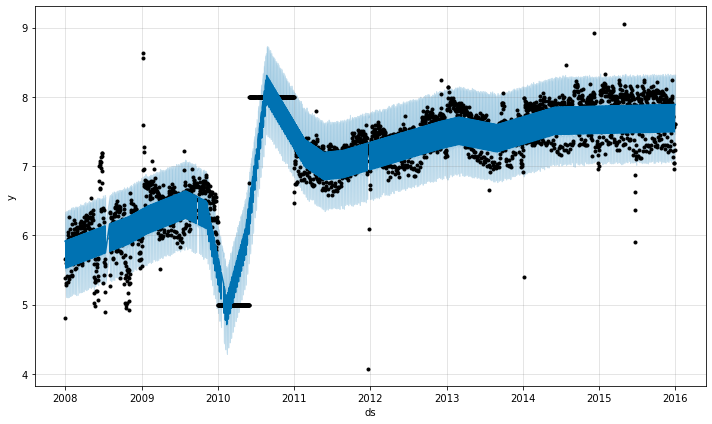

In [37]:
from fbprophet import Prophet
#Build the Model
linear = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='linear',interval_width=0.8)
linear.add_regressor('weekend')
# Prediction without Seasonality
linear = linear.fit(df)
forecast = linear.predict(df)
forecast['fact'] = df['y'].reset_index(drop = True)
fig1 = linear.plot(forecast)

Choose the first 3 years as history and make predictions for next year in every 180 days, crossvalidately.

In [38]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(linear, initial='1095 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  7.896066    7.286722    8.493391  6.935370 2011-01-21
1 2011-01-23  7.899495    7.294115    8.437109  6.888572 2011-01-21
2 2011-01-24  8.188102    7.568766    8.770569  7.228388 2011-01-21
3 2011-01-25  8.191530    7.604744    8.779250  7.262629 2011-01-21
4 2011-01-26  8.194959    7.580278    8.756565  7.298445 2011-01-21

**Performance metrics** for linear model without seasonality as a distance from the cut-off are printed.

In [39]:
from fbprophet.diagnostics import performance_metrics
df_p_linear = performance_metrics(df_cv)
df_p_linear.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.184510  0.429547  0.318634  0.043414  0.030168  0.837423
1 38 days  0.184251  0.429245  0.318498  0.043350  0.030509  0.839468
2 39 days  0.184349  0.429359  0.318774  0.043390  0.030131  0.836060
3 40 days  0.184417  0.429438  0.318159  0.043310  0.029997  0.837764
4 41 days  0.185753  0.430991  0.318806  0.043398  0.029877  0.836060

### Linear Model with Seasonality
The authors were working with a linear model with daily seasonality only, because their data was seismic. Since I am crunching web traffic data I donot expect to see daily seasonality but weeekly may be. So I built another linear model with yearly and weekly with seasonalities. I thought keeping using *weekends* as a exogenous regressor is a good idea as Duan and Zu did since web traffic changes of weekdays can be different from weekends, but  I did not make use of *US Hollidays* since Wikipedia can be accessed from any place in the Earth. 
While adding seasonalities, I followed [van der Merwe](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)'s suggestions and added the seperately. The advantange in doing so is to be able to define uncertainty for each seasonality, later.

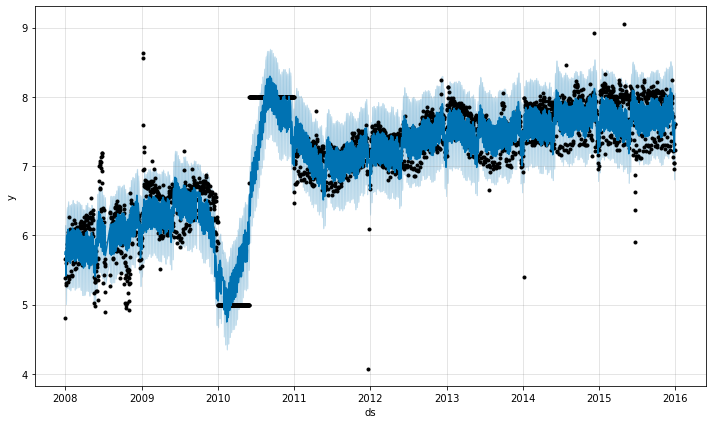

In [40]:
from fbprophet import Prophet
seasonal = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='linear',interval_width=0.8)
seasonal.add_seasonality(name = "weekly",period = 7, fourier_order=20)
seasonal.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
seasonal.add_regressor('weekend')
seasonal = seasonal.fit(df)
seasonal_forecast = seasonal.predict(df)
seasonal_forecast['fact'] = df['y'].reset_index(drop = True)
fig2 = seasonal.plot(seasonal_forecast)

In [42]:
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(seasonal, initial='1095 days', period='180 days', horizon = '365 days')
df_cv2.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  7.194557    6.753863    7.673007  6.935370 2011-01-21
1 2011-01-23  7.199320    6.701125    7.656254  6.888572 2011-01-21
2 2011-01-24  7.429496    6.959114    7.913808  7.228388 2011-01-21
3 2011-01-25  7.485522    7.028479    7.925644  7.262629 2011-01-21
4 2011-01-26  7.508075    7.087249    8.001488  7.298445 2011-01-21

**Performance metrics** as a distance from the cut-off are printed.

In [43]:
from fbprophet.diagnostics import performance_metrics
df_p_seasonal = performance_metrics(df_cv2)
df_p_seasonal.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.121396  0.348420  0.292393  0.039276  0.035013  0.828221
1 38 days  0.122002  0.349288  0.293418  0.039387  0.035361  0.828562
2 39 days  0.122530  0.350043  0.294751  0.039577  0.035151  0.828562
3 40 days  0.122143  0.349489  0.294584  0.039567  0.035151  0.826858
4 41 days  0.121785  0.348977  0.294186  0.039525  0.035031  0.826858

### Logistic Model without Seasonality

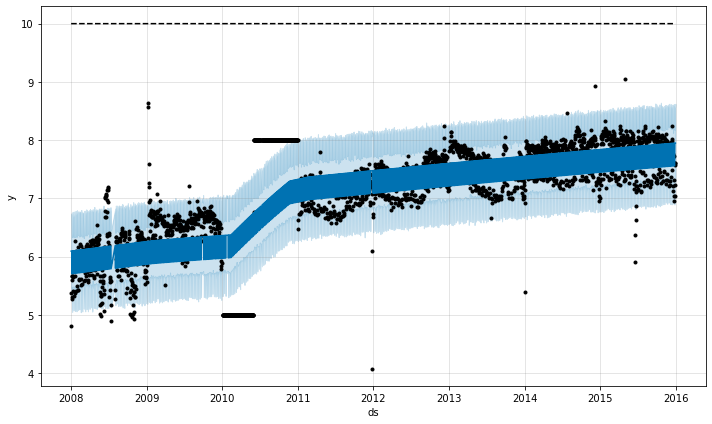

In [56]:
df['cap'] = 10
logistic2 = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='logistic',interval_width=0.8)
#logistic.add_seasonality(name = "weekly",period = 7, fourier_order=20)
#logistic.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
logistic2.add_regressor('weekend')
logistic2 = logistic2.fit(df)
logistic_forecast2 = logistic2.predict(df)
logistic_forecast2['fact'] = df['y'].reset_index(drop = True)
fig4 = logistic2.plot(logistic_forecast2)

In [58]:
df_cv4 = cross_validation(logistic2, initial='1095 days', period='180 days', horizon = '365 days')
df_cv4.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  8.122503    7.321123    8.954543  6.935370 2011-01-21
1 2011-01-23  8.128208    7.297410    8.930033  6.888572 2011-01-21
2 2011-01-24  8.413274    7.660162    9.208511  7.228388 2011-01-21
3 2011-01-25  8.418946    7.623286    9.283271  7.262629 2011-01-21
4 2011-01-26  8.424602    7.609804    9.259710  7.298445 2011-01-21

**Performance metrics** as a distance from the cut-off are printed.

In [59]:
from fbprophet.diagnostics import performance_metrics
df_p_logistic = performance_metrics(df_cv4)
df_p_logistic.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.244145  0.494110  0.339464  0.046290  0.030520  0.880368
1 38 days  0.242198  0.492136  0.337552  0.045968  0.029992  0.882072
2 39 days  0.241518  0.491445  0.336748  0.045828  0.029702  0.882072
3 40 days  0.241273  0.491195  0.335184  0.045592  0.029638  0.882072
4 41 days  0.242184  0.492122  0.334105  0.045435  0.029638  0.882072

### Logistic Model with Seasonality

Assuming that the visit count will saturate in the future, a logistic model is also built. As upper bound to capacity 10 is chosen because the growth seems to saturate around 8 and [Ruan van der Merwe](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) suggest making the cap to be a relatively high amount, but within common sense and 10 makes sense. From the plot, it is seen that the logistic model fits the data better. 

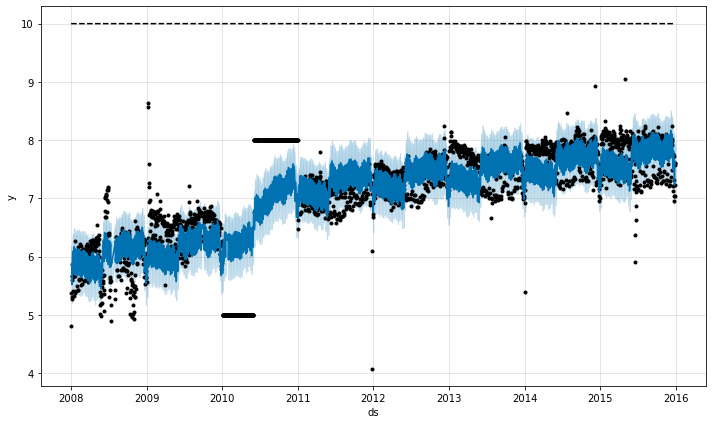

In [60]:
df['cap'] = 10
logistic = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='logistic',interval_width=0.5)
logistic.add_seasonality(name = "weekly",period = 7, fourier_order=20)
logistic.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
logistic.add_regressor('weekend')
logistic = logistic.fit(df)
logistic_forecast = logistic.predict(df)
logistic_forecast['fact'] = df['y'].reset_index(drop = True)
fig3 = logistic.plot(logistic_forecast)

In [54]:
df_cv3 = cross_validation(logistic, initial='1095 days', period='180 days', horizon = '365 days')
df_cv3.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  7.747976    7.095852    8.452811  6.935370 2011-01-21
1 2011-01-23  7.779852    7.128500    8.422919  6.888572 2011-01-21
2 2011-01-24  8.031453    7.363533    8.712112  7.228388 2011-01-21
3 2011-01-25  8.118170    7.442665    8.793211  7.262629 2011-01-21
4 2011-01-26  8.151825    7.505524    8.835296  7.298445 2011-01-21

**Performance metrics** as a distance from the cut-off are printed.

In [57]:
from fbprophet.diagnostics import performance_metrics
df_p_logistic = performance_metrics(df_cv3)
df_p_logistic.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.371608  0.609597  0.532007  0.072223  0.064435  0.676380
1 38 days  0.371089  0.609171  0.530508  0.071964  0.064435  0.679959
2 39 days  0.372367  0.610219  0.532073  0.072148  0.064891  0.679959
3 40 days  0.372043  0.609953  0.532013  0.072115  0.064578  0.679959
4 41 days  0.371787  0.609744  0.530956  0.071954  0.064578  0.683027

### Tight Logistic Model with Seasonality

interval_width is set to 0.3 which is lower than the default  (0.5)

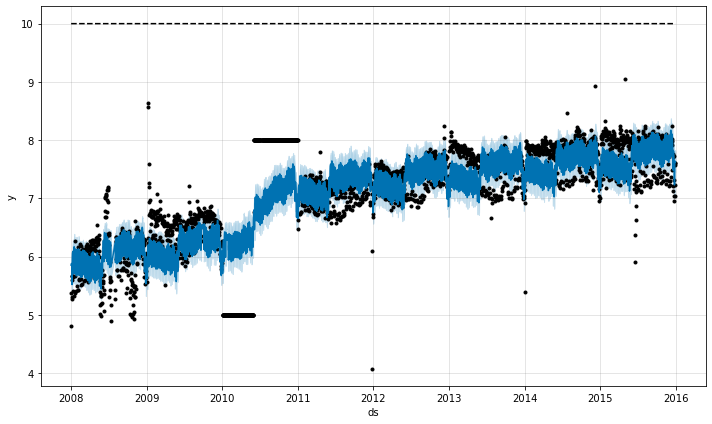

In [62]:
df['cap'] = 10
logisticTight = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='logistic',interval_width=0.3)
logisticTight.add_seasonality(name = "weekly",period = 7, fourier_order=20)
logisticTight.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
logisticTight.add_regressor('weekend')
logisticTight = logisticTight.fit(df)
tight_forecast = logisticTight.predict(df)
tight_forecast['fact'] = df['y'].reset_index(drop = True)
fig5 = logisticTight.plot(tight_forecast)

In [64]:
df_cv5 = cross_validation(logisticTight, initial='1095 days', period='180 days', horizon = '365 days')
df_cv5.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  7.747976    7.560538    7.939818  6.935370 2011-01-21
1 2011-01-23  7.779852    7.629038    8.021481  6.888572 2011-01-21
2 2011-01-24  8.031453    7.820680    8.209875  7.228388 2011-01-21
3 2011-01-25  8.118170    7.909674    8.301503  7.262629 2011-01-21
4 2011-01-26  8.151825    7.951278    8.359727  7.298445 2011-01-21

In [65]:
from fbprophet.diagnostics import performance_metrics
df_p_tight = performance_metrics(df_cv5)
df_p_tight.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.371608  0.609597  0.532007  0.072223  0.064435  0.101227
1 38 days  0.371089  0.609171  0.530508  0.071964  0.064435  0.103954
2 39 days  0.372367  0.610219  0.532073  0.072148  0.064891  0.100886
3 40 days  0.372043  0.609953  0.532013  0.072115  0.064578  0.097819
4 41 days  0.371787  0.609744  0.530956  0.071954  0.064578  0.099523

### Loose Logistic Model with Seasonality

interval_width is set to 0.95 which is higher than the default.

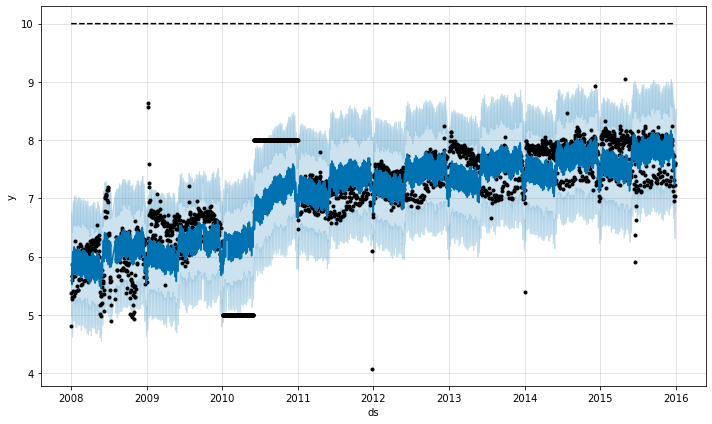

In [114]:
df['cap'] = 10
logisticLoose = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='logistic',interval_width=0.93)
logisticLoose.add_seasonality(name = "weekly",period = 7, fourier_order=20)
logisticLoose.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
logisticLoose.add_regressor('weekend')
logisticLoose = logisticLoose.fit(df)
loose_forecast = logisticLoose.predict(df)
loose_forecast['fact'] = df['y'].reset_index(drop = True)
fig6 = logisticLoose.plot(loose_forecast)

In [78]:
df_cv7 = cross_validation(logisticTight, initial='1095 days', period='180 days', horizon = '365 days')
df_cv7.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2011-01-21 00:00:00 and 2014-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2011-01-22  7.747976    6.999231    8.526753  6.935370 2011-01-21
1 2011-01-23  7.779852    7.028461    8.501063  6.888572 2011-01-21
2 2011-01-24  8.031453    7.310929    8.797699  7.228388 2011-01-21
3 2011-01-25  8.118170    7.386520    8.822881  7.262629 2011-01-21
4 2011-01-26  8.151825    7.460827    8.919237  7.298445 2011-01-21

In [79]:
from fbprophet.diagnostics import performance_metrics
df_p_loose = performance_metrics(df_cv7)
df_p_loose.head()

horizon       mse      rmse       mae      mape     mdape  coverage
0 37 days  0.371608  0.609597  0.532007  0.072223  0.064435  0.702454
1 38 days  0.371089  0.609171  0.530508  0.071964  0.064435  0.704499
2 39 days  0.372367  0.610219  0.532073  0.072148  0.064891  0.704499
3 40 days  0.372043  0.609953  0.532013  0.072115  0.064578  0.707566
4 41 days  0.371787  0.609744  0.530956  0.071954  0.064578  0.710634

### Loose Logistic Model without Seasonality

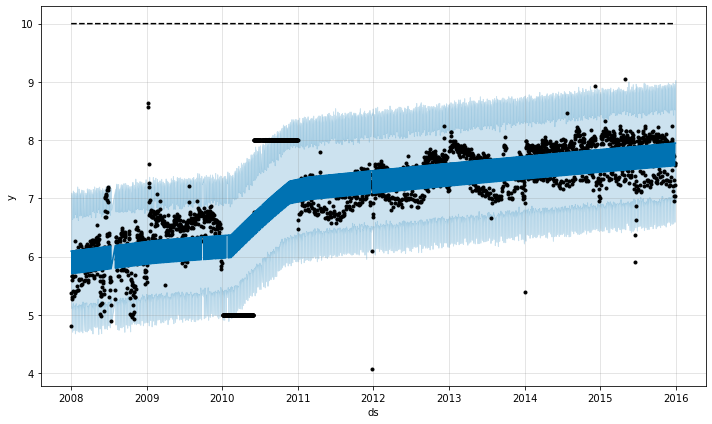

In [119]:
df['cap'] = 10
logisticLoose2 = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='logistic',interval_width=0.95)

#m.add_country_holidays(country_name='US')
logisticLoose2.add_regressor('weekend')
logisticLoose2 = logisticLoose2.fit(df)
loose_forecast2 = logisticLoose2.predict(df)
loose_forecast2['fact'] = df['y'].reset_index(drop = True)
fig6 = logisticLoose2.plot(loose_forecast2)

## Detecting Anomalies

The light blue boundaries are yhat_upper and yhat_lower defines the prediction interval. The points outside this interval is considered as outliers. The relative distance of an anomaly point to the closest boundary defines the importance of that specific point.

### Linear Model Without Seasonality:

In [11]:
forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
forecasted['anomaly'] = 0
forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
forecasted['importance'] = 0
forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
(forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
(forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

forecasted.head()

ds     trend      yhat  yhat_lower  yhat_upper      fact  anomaly  \
0 2008-01-01  5.916692  5.916692    5.512316    6.317886  5.976351        0   
1 2008-01-02  5.917847  5.917847    5.503185    6.354461  6.049733        0   
2 2008-01-03  5.919002  5.919002    5.523824    6.306962  6.011267        0   
3 2008-01-04  5.920158  5.920158    5.505616    6.341544  5.953243        0   
4 2008-01-05  5.921313  5.526753    5.123837    5.971289  5.910797        0   

   importance  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

The linear model with seasonality defines 845 points as anomalies.

In [50]:
forecasted.anomaly.abs().sum()

845

The plotting function is borrowed from [anomaly-detection-using-facebook-s-prophet.ipynb
](https://github.com/Diyago/ML-DL-scripts/blob/master/time%20series%20regression/anomaly%20detection/anomaly-detection-using-facebook-s-prophet.ipynb) notebook.

In [71]:
import altair as alt
#alt.renderers.enable('notebook')
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Log'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Page Visits'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              


In [72]:
plot_anomalies(forecasted)

alt.LayerChart(...)

### Linear Model With Seasonality:

In [44]:
seasonal_forecasted = seasonal_forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
seasonal_forecasted['anomaly'] = 0
seasonal_forecasted.loc[seasonal_forecasted['fact'] > seasonal_forecasted['yhat_upper'], 'anomaly'] = 1
seasonal_forecasted.loc[seasonal_forecasted['fact'] < seasonal_forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
seasonal_forecasted['importance'] = 0
seasonal_forecasted.loc[seasonal_forecasted['anomaly'] ==1, 'importance'] = \
(seasonal_forecasted['fact'] - seasonal_forecasted['yhat_upper'])/seasonal_forecast['fact']
seasonal_forecasted.loc[seasonal_forecasted['anomaly'] ==-1, 'importance'] = \
(seasonal_forecasted['yhat_lower'] - seasonal_forecasted['fact'])/seasonal_forecast['fact']

seasonal_forecasted.head()

ds     trend      yhat  yhat_lower  yhat_upper      fact  anomaly  \
0 2008-01-01  5.078493  5.728259    5.334487    6.151059  5.976351        0   
1 2008-01-02  5.079487  5.760248    5.335315    6.143046  6.049733        0   
2 2008-01-03  5.080480  5.771582    5.408317    6.145767  6.011267        0   
3 2008-01-04  5.081474  5.718796    5.330121    6.114779  5.953243        0   
4 2008-01-05  5.082467  5.417541    5.008684    5.816563  5.910797        1   

   importance  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.015943

The linear model with seasonality catches 904 points as outliers.

In [51]:
seasonal_forecasted.anomaly.abs().sum()

904

In [46]:
plot_anomalies(seasonal_forecasted)

alt.LayerChart(...)

### Tight Logistic Model With Seasonality:

In [67]:
tightly_forecasted = tight_forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
tightly_forecasted['anomaly'] = 0
tightly_forecasted.loc[tightly_forecasted['fact'] > tightly_forecasted['yhat_upper'], 'anomaly'] = 1
tightly_forecasted.loc[tightly_forecasted['fact'] < tightly_forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
tightly_forecasted['importance'] = 0
tightly_forecasted.loc[tightly_forecasted['anomaly'] ==1, 'importance'] = \
(tightly_forecasted['fact'] - tightly_forecasted['yhat_upper'])/tightly_forecasted['fact']
tightly_forecasted.loc[tightly_forecasted['anomaly'] ==-1, 'importance'] = \
(tightly_forecasted['yhat_lower'] - tightly_forecasted['fact'])/tightly_forecasted['fact']

tightly_forecasted.head()

ds     trend      yhat  yhat_lower  yhat_upper      fact  anomaly  \
0 2008-01-01  4.350741  5.851821    5.652134    6.007787  5.976351        0   
1 2008-01-02  4.351131  5.874704    5.696276    6.054387  6.049733        0   
2 2008-01-03  4.351520  5.882007    5.725489    6.081747  6.011267        0   
3 2008-01-04  4.351910  5.824376    5.641276    6.018946  5.953243        0   
4 2008-01-05  4.352299  5.520383    5.345681    5.678192  5.910797        1   

   importance  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.039352

In [68]:
tightly_forecasted.anomaly.abs().sum()

2001

In [70]:
plot_anomalies(tightly_forecasted)

alt.LayerChart(...)

### Loose Logistic Model With Seasonality:

In [111]:
loosely_forecasted = loose_forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
loosely_forecasted['anomaly'] = 0
loosely_forecasted.loc[loosely_forecasted['fact'] > loosely_forecasted['yhat_upper'], 'anomaly'] = 1
loosely_forecasted.loc[loosely_forecasted['fact'] < loosely_forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
loosely_forecasted['importance'] = 0
loosely_forecasted.loc[loosely_forecasted['anomaly'] ==1, 'importance'] = \
(loosely_forecasted['fact'] - loosely_forecasted['yhat_upper'])/loosely_forecasted['fact']
loosely_forecasted.loc[loosely_forecasted['anomaly'] ==-1, 'importance'] = \
(loosely_forecasted['yhat_lower'] - loosely_forecasted['fact'])/loosely_forecasted['fact']

loosely_forecasted.head()

ds     trend      yhat  yhat_lower  yhat_upper      fact  anomaly  \
0 2008-01-01  4.350741  5.851821    4.946757    6.698328  5.976351        0   
1 2008-01-02  4.351131  5.874704    5.053666    6.728302  6.049733        0   
2 2008-01-03  4.351520  5.882007    5.040382    6.745149  6.011267        0   
3 2008-01-04  4.351910  5.824376    4.926282    6.716012  5.953243        0   
4 2008-01-05  4.352299  5.520383    4.689260    6.473795  5.910797        0   

   importance  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [112]:
loosely_forecasted.anomaly.abs().sum()

336

In [113]:
plot_anomalies(loosely_forecasted)

alt.LayerChart(...)

### Loose Logistic Model without Seasonality

In [120]:
loosely_forecasted2 = loose_forecast2[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
loosely_forecasted2['anomaly'] = 0
loosely_forecasted2.loc[loosely_forecasted2['fact'] > loosely_forecasted2['yhat_upper'], 'anomaly'] = 1
loosely_forecasted2.loc[loosely_forecasted2['fact'] < loosely_forecasted2['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
loosely_forecasted2['importance'] = 0
loosely_forecasted2.loc[loosely_forecasted2['anomaly'] ==1, 'importance'] = \
(loosely_forecasted2['fact'] - loosely_forecasted2['yhat_upper'])/loosely_forecasted2['fact']
loosely_forecasted2.loc[loosely_forecasted2['anomaly'] ==-1, 'importance'] = \
(loosely_forecasted2['yhat_lower'] - loosely_forecasted2['fact'])/loosely_forecasted2['fact']

loosely_forecasted2.head()

ds     trend      yhat  yhat_lower  yhat_upper      fact  anomaly  \
0 2008-01-01  6.093692  6.093692    5.118262    7.099728  5.976351        0   
1 2008-01-02  6.094145  6.094145    5.144069    7.060638  6.049733        0   
2 2008-01-03  6.094597  6.094597    5.123918    7.083944  6.011267        0   
3 2008-01-04  6.095049  6.095049    5.096296    7.041437  5.953243        0   
4 2008-01-05  6.095502  5.705316    4.725798    6.648796  5.910797        0   

   importance  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [121]:
plot_anomalies(loosely_forecasted2)

alt.LayerChart(...)

## References

+ [Outlier Detection DataSets (ODDS)](http://odds.cs.stonybrook.edu/#table3)
+ [What are anomaly detection benchmark datasets?](https://www.researchgate.net/post/What_are_anomaly_detection_benchmark_datasets)
+ [Using Prophet for Anomaly Detection](https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473)
+ [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)
+ [EDA and Time Series Modeling](https://www.kaggle.com/grosvenpaul/eda-and-time-series-modeling?)
+ [Implementing Facebook Prophet efficiently](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)
+ [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go)
+ [Time series with trend and seasonality
components](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf)
+ [Multiplicative Seasonality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)
+ [Autocorrelation](https://otexts.com/fpp3/acf.html)
+ [Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)
+ [anomaly-detection-using-facebook-s-prophet.ipynb
](https://github.com/Diyago/ML-DL-scripts/blob/master/time%20series%20regression/anomaly%20detection/anomaly-detection-using-facebook-s-prophet.ipynb)